# Notebook for evaluating the model performance in predicting secondary outcomes associated with high-impact chronic pain

Here we evaluate cross-sectionally and longitudinally the ability of our psychosocial risk model to predict secondary outcomes including overall health rating, being unable to work due to sickness/disability, and opioid use.

# Contents
1. Preparing data
2. Derive the sparse model
3. Benchmark sparse model performance
4. Evaluate discriminatory utility of sparse model
5. Sparse model associations with experience of pain
6. Plotting


In [1]:
import numpy as np
import pandas as pd
import math
import os
from scipy import stats
from sklearn import pipeline, impute, preprocessing, decomposition, linear_model, model_selection, cross_decomposition, metrics, utils, inspection
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.rcParams['font.size'] = 14
sns.set(font="Arial")
plt.rcParams.update({'font.family':'Arial'})



# 1. Prepare and organize main dataframes

In [2]:
Folder = '/Volumes/MyBook/UKB_Files/Spreading/'

#### LOADING DATA ####
variables = pd.read_csv(Folder + '0_Variables_V3.csv')
variables = variables[variables.coding_finished==1]
variables_T0, variables_T2  = list((variables['Name'] + '_' + variables['T0']).values), list((variables['Name'] + '_' + variables['T2']).values)

W = pd.read_csv(Folder + 'Coefficients_PLSReg_3comp.csv')
variables['weights'] = W.Coefficients.values

preproc_UKB_T0, preproc_UKB_T2, preproc_UKB_B = pd.read_csv(Folder + '5_TrainData_PreprocFeatures_Adv.csv'), pd.read_csv(Folder + '5_TestData_PreprocFeatures_Adv.csv'), pd.read_csv(Folder + '6_BrainVisit_PreprocFeatures_Adv.csv')
preproc_UKB_T0['PLS'], preproc_UKB_T2['PLS'], preproc_UKB_B['PLS'] =  np.dot(preproc_UKB_T0[variables_T0], variables['weights']), np.dot(preproc_UKB_T2[variables_T0], variables['weights']), np.dot(preproc_UKB_B[variables_T2], variables['weights'])

# Loading and Computing Medication
Meds = pd.read_csv(Folder + '0_UKB_ATC_Medications.csv')
Meds['OPs_T0'], Meds['OPs_T2'] = np.where(Meds.filter(like='N02A').filter(like='_T0').sum(axis=1).values > 0, 1, 0), np.where(Meds.filter(like='N02A').filter(like='_T2').sum(axis=1).values > 0, 1, 0)
preproc_UKB_T0, preproc_UKB_T2, preproc_UKB_B = preproc_UKB_T0.merge(Meds[['eid', 'OPs_T0']], on = 'eid'), preproc_UKB_T2.merge(Meds[['eid', 'OPs_T0']], on = 'eid'), preproc_UKB_B.merge(Meds[['eid', 'OPs_T2']], on = 'eid')

#Matching Eids
list_eid = np.intersect1d(preproc_UKB_B.eid, preproc_UKB_T2.eid)
UKB_T2 = preproc_UKB_T2[preproc_UKB_T2.eid.isin(list_eid)].sort_values(by = 'eid').reset_index(drop=True)
UKB_B = preproc_UKB_B[preproc_UKB_B.eid.isin(list_eid)].sort_values(by = 'eid').reset_index(drop=True)
Meds = Meds[Meds.eid.isin(list_eid)].sort_values(by = 'eid').reset_index(drop=True)


# 2. Compute effect sizes
Here we will compute the effect sizes (AUC and Cohen's d) between our model score and subjects individual secondary measurement outcomes.

In [3]:
def cohen_d(x,y):
        return (np.mean(x) - np.mean(y)) / math.sqrt(((x.shape[0] - 1) * np.std(x, ddof=1) + (y.shape[0] - 1) * np.std(y, ddof=1)) / (x.shape[0] + y.shape[0] - 2))
#### Computing AUCs and cohen'd d fore secondary outcomes ####

# Health Rating
preproc_UKB_T0['one'], preproc_UKB_T2['one'] = 1, 1
gr_T0, gr_T2 = preproc_UKB_T0.groupby(by='OverallHealthRating_T0').one.sum(), preproc_UKB_T2.groupby(by='OverallHealthRating_T0').one.sum()
health_T0, health_T2 = dict({1:f"{gr_T0[1]:,}", 2:f"{gr_T0[2]:,}", 3:f"{gr_T0[3]:,}", 4:f"{gr_T0[4]:,}"}), dict({1:f"{gr_T2[1]:,}", 2:f"{gr_T2[2]:,}", 3:f"{gr_T2[3]:,}", 4:f"{gr_T2[4]:,}"})
H_R_T0, H_R_T2 = round(preproc_UKB_T0.OverallHealthRating_T0.corr(preproc_UKB_T0.PLS), 2), round(preproc_UKB_T2.OverallHealthRating_T0.corr(preproc_UKB_T2.PLS), 2)
H_D1_T0, H_D1_T2 = round(cohen_d(preproc_UKB_T0[preproc_UKB_T0.OverallHealthRating_T0==1].PLS, preproc_UKB_T0[preproc_UKB_T0.OverallHealthRating_T0==2].PLS), 2), round(cohen_d(preproc_UKB_T2[preproc_UKB_T2.OverallHealthRating_T0==1].PLS, preproc_UKB_T2[preproc_UKB_T2.OverallHealthRating_T0==2].PLS), 2)
H_D2_T0, H_D2_T2 = round(cohen_d(preproc_UKB_T0[preproc_UKB_T0.OverallHealthRating_T0==2].PLS, preproc_UKB_T0[preproc_UKB_T0.OverallHealthRating_T0==3].PLS), 2), round(cohen_d(preproc_UKB_T2[preproc_UKB_T2.OverallHealthRating_T0==2].PLS, preproc_UKB_T2[preproc_UKB_T2.OverallHealthRating_T0==3].PLS), 2)
H_D3_T0, H_D3_T2 = round(cohen_d(preproc_UKB_T0[preproc_UKB_T0.OverallHealthRating_T0==3].PLS, preproc_UKB_T0[preproc_UKB_T0.OverallHealthRating_T0==4].PLS), 2), round(cohen_d(preproc_UKB_T2[preproc_UKB_T2.OverallHealthRating_T0==3].PLS, preproc_UKB_T2[preproc_UKB_T2.OverallHealthRating_T0==4].PLS), 2)

# OPs and Unable to Work
Illness_T0, Illness_T2 = preproc_UKB_T0[['OPs_T0','PLS', 'UnableWorkDueSicknessDisability_T0']], preproc_UKB_T2[['OPs_T0','PLS', 'UnableWorkDueSicknessDisability_T0']]
TMP_T0, TMP_T2 = Illness_T0.dropna(subset = ['OPs_T0']), Illness_T2.dropna(subset = ['OPs_T0'])
fpr1_T0,tpr1_T0,_ = metrics.roc_curve(y_true = TMP_T0['OPs_T0'].values, y_score = TMP_T0['PLS'].values)
fpr1_T2,tpr1_T2,_ = metrics.roc_curve(y_true = TMP_T2['OPs_T0'].values, y_score = TMP_T2['PLS'].values)
AUC1_T0, AUC1_T2 = round(metrics.auc(fpr1_T0,tpr1_T0),2), round(metrics.auc(fpr1_T2,tpr1_T2),2)
Y1_T0, N1_T0 = TMP_T0[TMP_T0.OPs_T0==1].PLS, TMP_T0[TMP_T0.OPs_T0==0].PLS
Y1_T2, N1_T2 = TMP_T2[TMP_T2.OPs_T0==1].PLS, TMP_T2[TMP_T2.OPs_T0==0].PLS
cohen_d1_T0, cohen_d1_T2 = round(cohen_d(Y1_T0,N1_T0),2), round(cohen_d(Y1_T2,N1_T2),2)
Illness_T0['OPs_T0'], Illness_T2['OPs_T0'] = Illness_T0.OPs_T0.replace({1:"Yes (" + f"{Y1_T0.shape[0]:,}" +")", 0:"No (" + f"{N1_T0.shape[0]:,}" +")"}), Illness_T2.OPs_T0.replace({1:"Yes (" + f"{Y1_T2.shape[0]:,}" +")", 0:"No (" + f"{N1_T2.shape[0]:,}" +")"}) #Renaming number of participants 
TMP_T0, TMP_T2 = Illness_T0.dropna(subset = ['UnableWorkDueSicknessDisability_T0']), Illness_T2.dropna(subset = ['UnableWorkDueSicknessDisability_T0'])
fpr2_T0,tpr2_T0,_ = metrics.roc_curve(y_true = TMP_T0['UnableWorkDueSicknessDisability_T0'].values, y_score = TMP_T0['PLS'].values)
fpr2_T2,tpr2_T2,_ = metrics.roc_curve(y_true = TMP_T2['UnableWorkDueSicknessDisability_T0'].values, y_score = TMP_T2['PLS'].values)
AUC2_T0, AUC2_T2 = round(metrics.auc(fpr2_T0,tpr2_T0),2), round(metrics.auc(fpr2_T2,tpr2_T2),2)
Y2_T0,N2_T0 = TMP_T0[TMP_T0.UnableWorkDueSicknessDisability_T0==1].PLS, TMP_T0[TMP_T0.UnableWorkDueSicknessDisability_T0==0].PLS
Y2_T2,N2_T2 = TMP_T2[TMP_T2.UnableWorkDueSicknessDisability_T0==1].PLS, TMP_T2[TMP_T2.UnableWorkDueSicknessDisability_T0==0].PLS
cohen_d2_T0, cohen_d2_T2 = round(cohen_d(Y2_T0,N2_T0),2), round(cohen_d(Y2_T2,N2_T2),2)
Illness_T0['UnableWorkDueSicknessDisability_T0'], Illness_T2['UnableWorkDueSicknessDisability_T0'] = Illness_T0.UnableWorkDueSicknessDisability_T0.replace({1:"Yes (" + f"{Y2_T0.shape[0]:,}" +")", 0:"No (" + f"{N2_T0.shape[0]:,}" +")"}), Illness_T2.UnableWorkDueSicknessDisability_T0.replace({1:"Yes (" + f"{Y2_T2.shape[0]:,}" +")", 0:"No (" + f"{N2_T2.shape[0]:,}" +")"})
Illness_T0["all"], Illness_T2["all"] = "", ""

/var/folders/fb/fwsj02n54bd7zmtt541bh0140000gp/T/ipykernel_34764/913159828.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Illness_T0['OPs_T0'], Illness_T2['OPs_T0'] = Illness_T0.OPs_T0.replace({1:"Yes (" + f"{Y1_T0.shape[0]:,}" +")", 0:"No (" + f"{N1_T0.shape[0]:,}" +")"}), Illness_T2.OPs_T0.replace({1:"Yes (" + f"{Y1_T2.shape[0]:,}" +")", 0:"No (" + f"{N1_T2.shape[0]:,}" +")"}) #Renaming number of participants
/var/folders/fb/fwsj02n54bd7zmtt541bh0140000gp/T/ipykernel_34764/913159828.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [4]:
##### Secondary outcomes #####
# Create temporary (TMP) dataframe (DF) to do stats on.
# d = cohen'd, R = risk, P = persistent, Y = Yes, N = No
TMP_DF = pd.DataFrame({'OPs_T0': Meds.OPs_T0, 'OPs_T2': Meds.OPs_T2, 'PLS_T0': UKB_T2.PLS, 'NoWork_T0': UKB_T2.UnableWorkDueSicknessDisability_T0, 'NoWork_T2': UKB_B.UnableWorkDueSicknessDisability_T2}).dropna()
OP_T0, OP_T2 = TMP_DF.OPs_T0==0, TMP_DF.OPs_T2==0 #Opioid Prescription
NoW_T0, NoW_T2 = TMP_DF.NoWork_T0==0, TMP_DF.NoWork_T2==0
fpr_R1, tpr_R1, _ = metrics.roc_curve(y_true = TMP_DF[OP_T0].OPs_T2, y_score = TMP_DF[OP_T0].PLS_T0)  
fpr_R2, tpr_R2, _ = metrics.roc_curve(y_true = TMP_DF[NoW_T0].NoWork_T2, y_score = TMP_DF[NoW_T0].PLS_T0)    
fpr_P1, tpr_P1, _ = metrics.roc_curve(y_true = TMP_DF[~OP_T0].OPs_T2, y_score = TMP_DF[~OP_T0].PLS_T0)
fpr_P2, tpr_P2, _ = metrics.roc_curve(y_true = TMP_DF[~NoW_T0].NoWork_T2, y_score = TMP_DF[~NoW_T0].PLS_T0)    
aucR1, aucP1 = round(metrics.auc(fpr_R1,tpr_R1), 2), round(metrics.auc(fpr_P1,tpr_P1), 2)
aucR2, aucP2 = round(metrics.auc(fpr_R2,tpr_R2), 2), round(metrics.auc(fpr_P2,tpr_P2), 2)
YR1,NR1,YP1,NP1 = TMP_DF[OP_T0][~OP_T2].PLS_T0, TMP_DF[OP_T0][OP_T2].PLS_T0, TMP_DF[~OP_T0][~OP_T2].PLS_T0, TMP_DF[~OP_T0][OP_T2].PLS_T0
YR2,NR2,YP2,NP2 = TMP_DF[NoW_T0][~NoW_T2].PLS_T0, TMP_DF[NoW_T0][NoW_T2].PLS_T0, TMP_DF[~NoW_T0][~NoW_T2].PLS_T0, TMP_DF[~NoW_T0][NoW_T2].PLS_T0
dR1, dP1 = round(cohen_d(YR1, NR1), 2), round(cohen_d(NP1, YP1), 2)
dR2, dP2 = round(cohen_d(YR2, NR2), 2), round(cohen_d(NP2, YP2), 2)
pR1, pP1 = stats.ttest_ind(YR1, NR1, equal_var = False)[1], stats.ttest_ind(YP1, NP1, equal_var = False)[1]
pR2, pP2 = stats.ttest_ind(YR2, NR2, equal_var = False)[1], stats.ttest_ind(YP2, NP2, equal_var = False)[1]
TMP_DF['OP_Risk'] = TMP_DF[OP_T0].OPs_T2.replace({1:"Start Using\n(" + f"{YR1.shape[0]:,}" +")", 0:"Not Using\n(" + f"{NR1.shape[0]:,}" +")"})
TMP_DF['OP_Persist'] = TMP_DF[~OP_T0].OPs_T2.replace({0:"Stop Using\n(" + f"{YP1.shape[0]:,}" +")", 1:"Still Using\n(" + f"{NP1.shape[0]:,}" +")"})
TMP_DF['NoWork_Risk'] = TMP_DF[NoW_T0].NoWork_T2.replace({1:"Becomes Unable\n(" + f"{YR2.shape[0]:,}" +")", 0:"Able\n(" + f"{NR2.shape[0]:,}" +")"})
TMP_DF['NoWork_Persist'] = TMP_DF[~NoW_T0].NoWork_T2.replace({0:"Becomes Able\n(" + f"{YP2.shape[0]:,}" +")", 1:"Still Unable\n(" + f"{NP2.shape[0]:,}" +")"})
TMP_DF["X"] = ""

/var/folders/fb/fwsj02n54bd7zmtt541bh0140000gp/T/ipykernel_34764/3543579959.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  YR1,NR1,YP1,NP1 = TMP_DF[OP_T0][~OP_T2].PLS_T0, TMP_DF[OP_T0][OP_T2].PLS_T0, TMP_DF[~OP_T0][~OP_T2].PLS_T0, TMP_DF[~OP_T0][OP_T2].PLS_T0
/var/folders/fb/fwsj02n54bd7zmtt541bh0140000gp/T/ipykernel_34764/3543579959.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  YR2,NR2,YP2,NP2 = TMP_DF[NoW_T0][~NoW_T2].PLS_T0, TMP_DF[NoW_T0][NoW_T2].PLS_T0, TMP_DF[~NoW_T0][~NoW_T2].PLS_T0, TMP_DF[~NoW_T0][NoW_T2].PLS_T0


# 3. Overall health and model score
Computing the association of the residuals of our model with overall health rating from timepoint 1 to timepoint 2. We can see from the heatmap that the model tracks well with health ratings across timepoints (higher model score = more likely to remain in poor health and vice-versa).

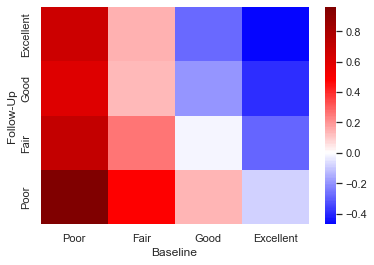

In [27]:
UKB_T2['NCPS'], UKB_B['NCPS'] = np.where((UKB_T2.NumberChronicPainTypes_T0 > 4) | (UKB_T2.ChronicWidespreadPain_T0 == 1), 4, UKB_T2.NumberChronicPainTypes_T0), np.where((UKB_B.NumberChronicPainTypes_T2 > 4) | (UKB_B.ChronicWidespreadPain_T2 == 1), 4, UKB_B.NumberChronicPainTypes_T2)
UKB_T2['NCPS2'], UKB_B['NCPS2'] = UKB_T2.NCPS**2, UKB_B.NCPS**2
UKB_T2['OHR2'], UKB_B['OHR2'] = UKB_T2.OverallHealthRating_T0**2, UKB_B.OverallHealthRating_T2**2
#V, V2 = 'NCPS', 'NCPS2' # Variable to Control for at T0
V, V2 = 'OverallHealthRating_T0', 'OHR2' # Variable to Control for at T0
UKB_B['Change_Age'], UKB_T2['Change_Age'] = (UKB_B.Age_T2 - UKB_T2.Age_T0), (UKB_B.Age_T2 - UKB_T2.Age_T0) #Change in Age

# Calculate residuals in PLS
reg = linear_model.LinearRegression()
T2_r = UKB_T2[[V, V2, 'Age_T0', 'Change_Age']].fillna(UKB_T2[[V, V2, 'Age_T0', 'Change_Age']].median())
reg_tmp = reg.fit(T2_r, UKB_T2.PLS).predict(T2_r)
UKB_B['PLS2'], UKB_T2['PLS2'] = stats.zscore(UKB_T2.PLS - reg_tmp), stats.zscore(UKB_T2.PLS - reg_tmp)

UKB_T2['OHR'] = np.where(UKB_T2.OverallHealthRating_T0 > 3, 3, UKB_T2.OverallHealthRating_T0)
UKB_B['OHR'] = np.where(UKB_B.OverallHealthRating_T2 > 3, 3, UKB_B.OverallHealthRating_T2)
UKB_T2['Change_OHR'] = UKB_B.OverallHealthRating_T2 - UKB_T2.OverallHealthRating_T0 

#### Matrix of Overall Health Rating
mat, mat_HR = np.zeros((4,4)), np.zeros((4,4))
for i in range(1,5):
    for j in range(1,5):
        HR_F = (UKB_T2.OverallHealthRating_T0==i) & (UKB_B.OverallHealthRating_T2==j)
        mat[j-1,i-1] =  len(UKB_T2[HR_F])
        mat_HR[j-1,i-1] =  UKB_T2[HR_F].PLS.mean()
mat= mat.astype(int)  
HR_change = pd.DataFrame(data = np.round(mat_HR,2), columns = pd.Series(data=['Poor', 'Fair', 'Good','Excellent'], name = 'Baseline'), index = pd.Series(data=['Poor', 'Fair', 'Good','Excellent'], name = 'Follow-Up'))

sns.heatmap(data = HR_change.T[['Excellent', 'Good', 'Fair', 'Poor']].T, cmap = 'seismic', center = 0)

mat, CP_mat, CP_D_mat, CP_AUC_mat= np.zeros((6,6)), np.zeros((6,6)), np.zeros((6,6)), np.zeros((6,6))


# 6. Plotting results
Our results show medium to large effect sizes using the psychosocial model to predict secondary health outcomes both cross-sectionally and longitudinally

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/fb/fwsj02n54bd7zmtt541bh0140000gp/T/ipykernel_34764/1257388756.py:115: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


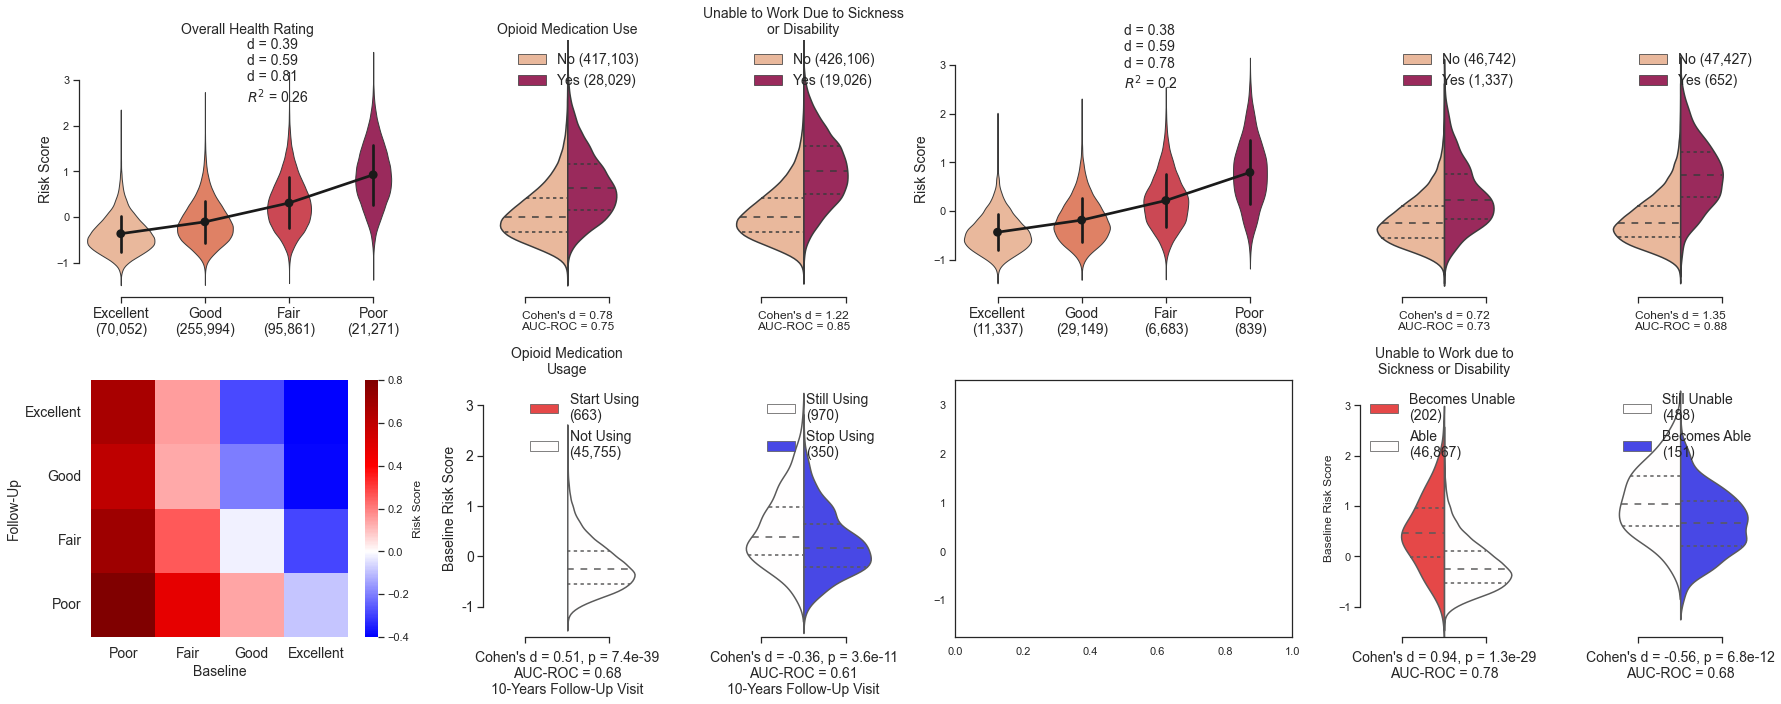

In [29]:
#Plotting

####  Model Evaluation ####

plt.rcParams['font.size'] = 14
sns.set_style("white")
fig, axs = plt.subplots(ncols=6, nrows=2,  figsize=(25, 10), gridspec_kw={'width_ratios': [2,1,1,2,1,1]})
# Figure Train: Health Rating
axs[0,0].set_xlim(0.5,4.5), axs[1,3].set_ylim(-1.75, 3.5)
sns.violinplot(ax = axs[0,0], x = abs(preproc_UKB_T0.OverallHealthRating_T0-5), y = preproc_UKB_T0.PLS, linewidth=1, inner=None, palette = sns.color_palette('rocket_r', 6)[0:4])
sns.pointplot(ax = axs[0,0], x = abs(preproc_UKB_T0.OverallHealthRating_T0-5), y = preproc_UKB_T0.PLS, color = 'k', ci = 'sd', scatter_kws={'s':100})
axs[0,0].annotate(xy = (1.5,2.5), text = "d = " +str(H_D3_T0) + "\nd = " + str(H_D2_T0) + "\nd = " + str(H_D1_T0) + "\n$R^2$ = " + str(round(H_R_T0**2,2)))
axs[0,0].spines['bottom'].set_bounds((0, 3))
axs[0,0].set_xticklabels(['Excellent\n('+str(health_T0[4])+')','Good\n('+str(health_T0[3])+')','Fair\n('+str(health_T0[2])+')','Poor\n('+str(health_T0[1])+')'], fontsize=14)
axs[0,0].set_yticks(np.arange(-1,4)), axs[0,0].spines['left'].set_bounds((-1, 3))
axs[0,0].set_title('Overall Health Rating', fontdict={'fontsize': 14})
axs[0,0].set_xlabel(''), axs[0,0].set_ylabel('Risk Score', fontsize = 14)
axs[0,0].legend(frameon=False, fontsize = 14)
axs[0,0].tick_params(left=True, bottom=True)
axs[0,0].spines['right'].set_visible(False), axs[0,0].spines['top'].set_visible(False)
# Figure Train: Opioids
sns.violinplot(ax = axs[0,1], data=Illness_T0, x="all", y='PLS', hue='OPs_T0', split=True, inner="quartile", palette = [sns.color_palette('rocket_r', 6)[0], sns.color_palette('rocket_r', 6)[3]])
axs[0,1].legend(frameon=False, fontsize = 14)
axs[0,1].set_ylim(-1.75, 3.5), axs[0,1].set_xticks([-0.25,0.25])
axs[0,1].set_title('Opioid Medication Use', fontdict={'fontsize': 14})
axs[0,1].set_xlabel("Cohen's d = " +str(cohen_d1_T0) + "\nAUC-ROC = " +str(AUC1_T0)), axs[0,1].set_ylabel(''), axs[0,1].set_yticks([])
axs[0,1].tick_params(bottom=True)
axs[0,1].spines['top'].set_visible(False), axs[0,1].spines['right'].set_visible(False), axs[0,1].spines['left'].set_visible(False)
axs[0,1].spines['bottom'].set_bounds((-0.25, 0.25))
# Figure Train: Unable
sns.violinplot(ax = axs[0,2], data=Illness_T0, x="all", y='PLS', hue='UnableWorkDueSicknessDisability_T0', split=True, inner="quartile", palette = [sns.color_palette('rocket_r', 6)[0], sns.color_palette('rocket_r', 6)[3]])
axs[0,2].legend(frameon=False, fontsize = 14)
axs[0,2].set_ylim(-1.75, 3.5), axs[0,2].set_xticks([-0.25,0.25])
axs[0,2].set_title('Unable to Work Due to Sickness\nor Disability', fontdict={'fontsize': 14})
axs[0,2].set_xlabel("Cohen's d = " +str(cohen_d2_T0) + "\nAUC-ROC = " +str(AUC2_T0)), axs[0,2].set_ylabel(''), axs[0,2].set_yticks([])
axs[0,2].tick_params(left=True, bottom=True)
axs[0,2].spines['right'].set_visible(False), axs[0,2].spines['top'].set_visible(False), axs[0,2].spines['left'].set_visible(False)
axs[0,2].spines['bottom'].set_bounds((-0.25, 0.25))
# Figure Test: Health Rating
axs[0,3].set_xlim(0.5,4.5), axs[0,3].set_ylim(-1.75, 3.5)
sns.violinplot(ax = axs[0,3], x = abs(preproc_UKB_T2.OverallHealthRating_T0-5), y = preproc_UKB_T2.PLS, linewidth=1, inner=None, palette = sns.color_palette('rocket_r', 6)[0:4])
sns.pointplot(ax = axs[0,3], x = abs(preproc_UKB_T2.OverallHealthRating_T0-5), y = preproc_UKB_T2.PLS, color = 'k', ci = 'sd', scatter_kws={'s':100})
axs[0,3].annotate(xy = (1.5,2.5), text = "d = " +str(H_D3_T2) + "\nd = " + str(H_D2_T2) + "\nd = " + str(H_D1_T2) + "\n$R^2$ = " + str(round(H_R_T2**2,2)))
axs[0,3].spines['bottom'].set_bounds((0, 3))
axs[0,3].set_xticklabels(['Excellent\n('+str(health_T2[4])+')','Good\n('+str(health_T2[3])+')','Fair\n('+str(health_T2[2])+')','Poor\n('+str(health_T2[1])+')'], fontsize=14)
axs[0,3].set_yticks(np.arange(-1,4)), axs[0,3].spines['left'].set_bounds((-1, 3))
axs[0,3].set_xlabel(''), axs[0,3].set_ylabel('Risk Score', fontsize = 14)
axs[0,3].legend(frameon=False, fontsize = 14)
axs[0,3].tick_params(left=True, bottom=True)
axs[0,3].spines['right'].set_visible(False), axs[0,3].spines['top'].set_visible(False)
# Figure Test: Opioids
sns.violinplot(ax = axs[0,4], data=Illness_T2, x="all", y='PLS', hue='OPs_T0', split=True, inner="quartile", palette = [sns.color_palette('rocket_r', 6)[0], sns.color_palette('rocket_r', 6)[3]])
axs[0,4].legend(frameon=False, fontsize = 14)
axs[0,4].set_ylim(-1.75, 3.5), axs[0,4].set_xticks([-0.25,0.25])
axs[0,4].set_xlabel("Cohen's d = " +str(cohen_d1_T2) + "\nAUC-ROC = " +str(AUC1_T2)), axs[0,4].set_ylabel(''), axs[0,4].set_yticks([])
axs[0,4].tick_params(bottom=True)
axs[0,4].spines['top'].set_visible(False), axs[0,4].spines['right'].set_visible(False), axs[0,4].spines['left'].set_visible(False)
axs[0,4].spines['bottom'].set_bounds((-0.25, 0.25))
# Figure Test: Unable
sns.violinplot(ax = axs[0,5], data=Illness_T2, x="all", y='PLS', hue='UnableWorkDueSicknessDisability_T0', split=True, inner="quartile", palette = [sns.color_palette('rocket_r', 6)[0], sns.color_palette('rocket_r', 6)[3]])
axs[0,5].legend(frameon=False, fontsize = 14)
axs[0,5].set_ylim(-1.75, 3.5), axs[0,5].set_xticks([-0.25,0.25])
axs[0,5].set_xlabel("Cohen's d = " +str(cohen_d2_T2) + "\nAUC-ROC = " +str(AUC2_T2)), axs[0,5].set_ylabel(''), axs[0,5].set_yticks([])
axs[0,5].tick_params(left=True, bottom=True)
axs[0,5].spines['right'].set_visible(False), axs[0,5].spines['top'].set_visible(False), axs[0,5].spines['left'].set_visible(False)
axs[0,5].spines['bottom'].set_bounds((-0.25, 0.25))
# Figure for Risk & Persistence of Opioids
# Risk Opioids
sns.violinplot(ax = axs[1,1], data=TMP_DF, x="X", y='PLS_T0', hue='OP_Risk', hue_order = ['Start Using\n(663)','Not Using\n(45,755)'], split=True, inner="quartile", palette = [sns.color_palette('bwr', 10)[9], sns.color_palette('bwr', 7)[3]])
axs[1,1].legend(frameon=False, fontsize = 14)
axs[1,1].spines['left'].set_bounds((-1, 3))
axs[1,1].set_ylim(-1.6, 3.5), axs[1,1].set_ylabel('Baseline Risk Score', fontsize = 14)
axs[1,1].set_yticks(np.arange(-1,4,1)), axs[1,1].set_yticklabels([-1,0,1,2,3], fontsize = 14)
axs[1,1].set_title('Opioid Medication\nUsage', fontdict={'fontsize': 14})
axs[1,1].set_xlabel("Cohen's d = " + str(dR1) + ", p = 7.4e-39\nAUC-ROC = " + str(aucR1) + "\n10-Years Follow-Up Visit", fontsize = 14)
axs[1,1].tick_params(left=True, bottom=True), axs[1,1].set_xticks([-0.25,0.25])
axs[1,1].spines['right'].set_visible(False), axs[1,1].spines['top'].set_visible(False)
axs[1,1].spines['bottom'].set_bounds((-0.25, 0.25))
# Recovery Opioids
sns.violinplot(ax = axs[1,2], data=TMP_DF, x="X", y='PLS_T0', hue='OP_Persist', hue_order = ['Still Using\n(970)', 'Stop Using\n(350)'], split=True, inner="quartile", palette = [sns.color_palette('bwr', 7)[3], sns.color_palette('bwr', 10)[0]])
axs[1,2].legend(frameon=False, fontsize = 14)
axs[1,2].spines['left'].set_bounds((-1, 3)), axs[1,2].set_ylim(-1.6, 3.5)
#axs[1,2].tick_params(left=True, bottom=True), axs[1,2].set_ylabel('Score at\nBaseline Visit', fontsize = 14), axs[1,2].set_yticks(np.arange(-1,4,1)), axs[1,2].set_yticklabels([-1,0,1,2,3], fontsize = 14)
axs[1,2].set_yticklabels([], fontsize = 14), axs[1,2].set_ylabel('', fontsize = 14), axs[1,2].spines['left'].set_visible(False), axs[1,2].tick_params(left=False, bottom=True)
axs[1,2].set_xlabel("Cohen's d = " + str(dP1) + ", p = 3.6e-11\nAUC-ROC = " + str(aucP1)+ "\n10-Years Follow-Up Visit", fontsize = 14)
axs[1,2].set_xticks([-0.25,0.25])
axs[1,2].spines['right'].set_visible(False), axs[1,2].spines['top'].set_visible(False)
axs[1,2].spines['bottom'].set_bounds((-0.25, 0.25))
# Risk Unable to Work
sns.violinplot(ax = axs[1,4], data=TMP_DF, x="X", y='PLS_T0', hue='NoWork_Risk', hue_order = ['Becomes Unable\n(202)','Able\n(46,867)'], split=True, inner="quartile", palette = [sns.color_palette('bwr', 10)[9], sns.color_palette('bwr', 7)[3]])
axs[1,4].legend(frameon=False, fontsize = 14)
axs[1,4].spines['left'].set_bounds((-1, 3))
axs[1,4].set_ylim(-1.6, 3.5), axs[1,4].set_ylabel('Baseline Risk Score'), axs[1,4].set_yticks(np.arange(-1,4,1))
axs[1,4].set_title('Unable to Work due to\nSickness or Disability', fontdict={'fontsize': 14})
axs[1,4].set_xlabel("Cohen's d = " + str(dR2) + ", p = 1.3e-29\nAUC-ROC = " + str(aucR2), fontsize = 14)
axs[1,4].tick_params(left=True, bottom=True), axs[1,4].set_xticks([-0.25,0.25])
axs[1,4].spines['right'].set_visible(False), axs[1,4].spines['top'].set_visible(False), axs[1,4]
axs[1,4].spines['bottom'].set_bounds((-0.25, 0.25))
# Recovery Unable to Work
sns.violinplot(ax = axs[1,5], data=TMP_DF, x="X", y='PLS_T0', hue='NoWork_Persist', hue_order = ['Still Unable\n(488)', 'Becomes Able\n(151)'], split=True, inner="quartile", palette = [sns.color_palette('bwr', 7)[3], sns.color_palette('bwr', 10)[0]])
axs[1,5].legend(frameon=False, fontsize = 14)
axs[1,5].spines['left'].set_bounds((-1, 3))
axs[1,5].set_ylim(-1.6, 3.5), axs[1,5].set_ylabel(''), axs[1,5].set_yticklabels([]), axs[1,5].set_yticks(np.arange(-1,4,1)), axs[1,5].set_yticklabels([])
axs[1,5].set_xlabel("Cohen's d = " + str(dP2) + ", p = 6.8e-12\nAUC-ROC = " + str(aucP2), fontsize = 14)
axs[1,5].tick_params(left=False, bottom=True), axs[1,5].set_xticks([-0.25,0.25])
axs[1,5].spines['right'].set_visible(False), axs[1,5].spines['top'].set_visible(False), axs[1,5].spines['left'].set_visible(False)
axs[1,5].spines['bottom'].set_bounds((-0.25, 0.25))

### Heatmap
sns.heatmap(ax = axs[1,0], data = HR_change.T[['Excellent', 'Good', 'Fair', 'Poor']].T, cmap = 'seismic', center = 0, vmin = -0.4, vmax = 0.8, square = True, linewidths=0, annot = False, cbar = True, cbar_kws = {'label': "Risk Score"}, annot_kws={"fontsize": 14}) 
axs[1,0].set_xticklabels(axs[1,0].get_xmajorticklabels(), fontsize = 14, rotation = 0), axs[1,0].set_yticklabels(axs[1,0].get_ymajorticklabels(), fontsize = 14, rotation = 0)
axs[1,0].set_xlabel(axs[1,0].get_xlabel(), fontsize = 14), axs[1,0].set_ylabel(axs[1,0].get_ylabel(), fontsize = 14)

fig.tight_layout()
fig.show()